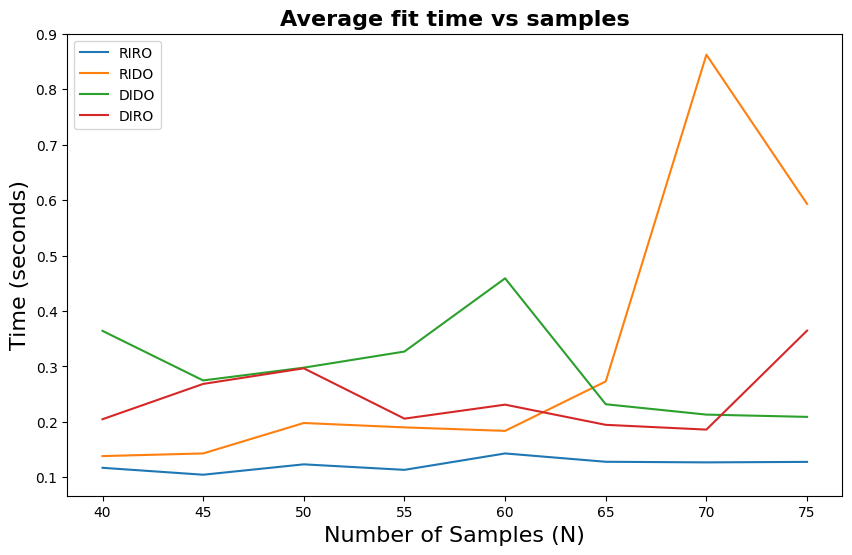

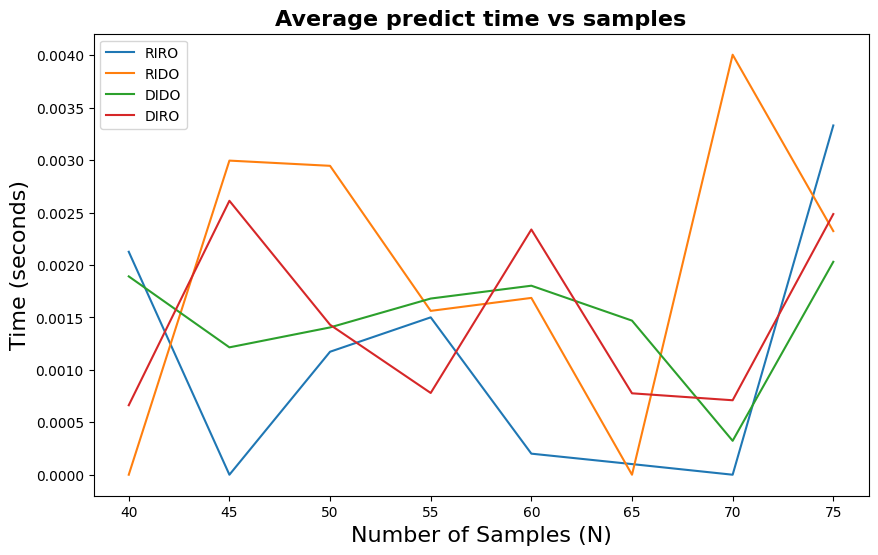

In [3]:
import random
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from tree import base
import metrics

np.random.seed(42)
num_average_time = 10  # Number of times to run each experiment to calculate the average values


def create_dataset(N, M, case, values=(1, 2)):
    if case == "RIRO":
        X = pd.DataFrame(np.random.choice(values, size=(N, M)))
        y = pd.Series(np.random.randn(N))

    elif case == "RIDO":
        X = pd.DataFrame(np.random.choice(values, size=(N, M)))
        y = pd.Series(np.random.randint(len(values), size=N))

    elif case == "DIDO":
        X = pd.DataFrame({i: pd.Series(np.random.choice(values, size=N), dtype=values[0].dtype) for i in range(M)})
        y = pd.Series(np.random.randint(len(values), size=N))

    else:  # DIRO
        X = pd.DataFrame({i: pd.Series(np.random.choice(values, size=N), dtype=values[0].dtype) for i in range(M)})
        y = pd.Series(np.random.randn(N))

    X_train = X[0:int(0.7 * N)]  # 70% for training
    X_test = X[int(0.7 * N):].reset_index(drop=True)  # 30% for testing
    y_train = y[0:int(0.7 * N)]
    y_test = y[int(0.7 * N):].reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

# Function to calculate average time (and std) taken by fit() and predict() for different N and P for 4 different cases of DTs

def fit_predict_time(X_train, X_test, y_train, y_test, case):
    # if case[2:] == "RO":
    #     model = DecisionTreeRegressor()
    # else:
    #     model = DecisionTreeClassifier()
    
    model = base.DecisionTree(criterion="information_gain")

    start_time_fit = time.time()
    model.fit(X_train, y_train)
    end_time_fit = time.time()
    fit_time = end_time_fit - start_time_fit

    start_time_pred = time.time()
    y_pred = model.predict(X_test)
    end_time_pred = time.time()
    predict_time = end_time_pred - start_time_pred

    return fit_time, predict_time

fit_times_all = {"RIRO": [], "RIDO": [], "DIDO": [], "DIRO": []}
predict_times_all = {"RIRO": [], "RIDO": [], "DIDO": [], "DIRO": []}

for case in ["RIRO", "RIDO", "DIDO", "DIRO"]:
    fit_times = []
    predict_times = []

    for n in range(40, 80, 5):
        for m in range(2, 8, 2):
            F = []
            P = []

            for i in range(num_average_time):
                N = n
                M = m
                
                if case[:2] == "RI":
                    X_train, X_test, y_train, y_test = create_dataset(N, M, case, values = (np.random.rand(),np.random.rand()))
                fit_time, predict_time = fit_predict_time(X_train, X_test, y_train, y_test, case)
                #print(f"case: {case}, {fit_time}")
                F.append(fit_time)
                P.append(predict_time)

        fit_times.append(np.sum(F) / len(F))
        predict_times.append(np.sum(P) / len(P))
    
    #print(fit_times_all)
    fit_times_all[case] = fit_times
    predict_times_all[case] = predict_times

# Plotting results
plt.figure(figsize=(10, 6))
for case in ["RIRO", "RIDO", "DIDO", "DIRO"]:
    plt.plot(range(40, 80, 5), fit_times_all[case], label=f"{case}")
    plt.xlabel("Number of Samples (N)", fontdict = {'fontsize': 16})
    plt.ylabel("Time (seconds)", fontdict = {'fontsize': 16})

plt.title("Average fit time vs samples", fontdict = {'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.show()

# Plotting results
plt.figure(figsize=(10, 6))
for case in ["RIRO", "RIDO", "DIDO", "DIRO"]:
    plt.plot(range(40, 80, 5), predict_times_all[case], label=f"{case}")
    plt.xlabel("Number of Samples (N)", fontdict = {'fontsize': 16})
    plt.ylabel("Time (seconds)", fontdict = {'fontsize': 16})

plt.title("Average predict time vs samples", fontdict = {'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.show()


**Time Complexity for Construction of the decision tree:**

* _For real input:_

>Time complexity of info gain function: When an input series of size N is given to the function, it will have to calculate the information gain for all the possible splits and return the split with the maximum information gain. The function requires $O(N)$ time to calculate the variance (for real output) or info gain (for discrete output) for a particular split with an input size of N. Since there are a total of $(N-1)$ possible splits, the function has a time complexity of $O(N^2)$.

>Now, we must iterate over each column (with N samples), pass it to the variance / information gain function, and determine which column provides the maximum information gain / minimum loss on the split. Since there are M columns, we will need to provide each of the M columns to the function during each recursive call. Also, we need to iterate over the N samples of the Mth column.. The theoretical time complexity comes out to be $O(M*N^3).$

* _For discrete input:_

>Time complexity of info gain function: When an input series of size N given to the info gain function, it traverses the full dataset $N$ times in the worst case (if there are N distinct values in the series), making the complexity $O(N)$. Since M columns are passed through the info gain function, each recursion will take order $O(N*M)$ time.

>_When the product of all unique attributes from each of the columns is lesser than the sample size($N$)_: The total number of combinations for a row in the input set is determined by multiplying the unique attributes of each column. If this value is less than the total number of samples, the maximum possible iteration will be one less than this product. Represented as $p_u$, this value follows an order of $d_u^M$, where $d_u$ is the number of unique attributes in any column u.

>_If the product of unique attributes in each column exceeds the sample size $(N)$: In a the decision tree every non-leaf node has at least two children. So, the maximum number of nodes and recursive iterations is $(N-1)$. Therefore, the code will go through a total of $(N-1)$ iterations in the worst-case.


Thus, 
1. For continuous input, the time complexity to construct the tree is $O(N^3M)$ 
2. In the case of discrete inputs, it is  $O(min(p_u,N)MN)  -> O((d_u^M+N)MN)$.

<br>

**Time Complexity for Prediction of the output:**

The prediction complexity is equal to the depth of the decision tree.

*   _Continuous Input_: The depth of the decision tree is affected by N only; the depth of the tree can not exceed $(N-1)$. But the number of attributes (M) does not affect the depth of the decision tree because a node can split on the same attribute value more than once. Thus, each search operation takes $O(N)$ time.
*    _Discrete Input_: The depth of the decision tree is affected by both the number of attributes (N) and the distinct values each attribute can take $(d_u)$. The depth cannot be greater than M because any node cannot have repeated attributes in the discrete case. Thus, each prediction operation takes $O(min(N,M))$ time.

Since the prediction input data has $N'$ samples, the prediction complexity is: 1. Continuous Input : $O(N*N')$ 2. Discrete Input : $O(min(M,N)*N')$


**Comparing the experimental time complexity with the one obtained theoretically:**

>* In conclusion, it is evident that the time required rises(increases) with the increase of both $M$ and $N$ for both real and discrete inputs.

>>1.  Real inputs: Although the theoretical complexity increases significantly with N, this is mainly true for very large datasets. In smaller datasets, the time per iteration is low, and the actual time taken depends largely on the dataset rather than the theoretical upper bound. For large enough N with considerable M values, a sharp rise in time becomes noticeable.
>>2. Discrete Inputs: In small datasets, outcomes can be non-deterministic due to their size. However, for large N values, there is an exponential increase in time complexity even with a small increase in M. This increase is more gradual for smaller N values.



>* For prediction:

>>Though we noticed a consistent rise in construction time for decision tree building, the same uniform trend didn't apply to prediction. Prediction time is predominantly influenced by the depth of the node, a value that varies significantly with the data and allows only an upper bound estimation. Consequently, the line graph illustrates the increase of the slope in relation to the rise in both $N$ and $M$.

  



